In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import FinancialMachineLearning as fml

### Chapter 15. Understanding Strategy Risk

#### Exercise 1
포트폴리오 매니저가 연환산 SR이 2가 되는 목표를 달성할 수 있는 전략을 실행하고자 한다. 베팅은 Precision이 60%이고, 주별 빈도를 가지고 있다. 청산 조건은 이익 실현이 2%, 손절이 -2%이다

**(a)** 전략이 생존 가능한가?

In [3]:
def runSRtrials(p, pt = 1, sl = 1, trials = 100000):
    out = []
    for i in range(trials):
        rnd = np.random.binomial(n = 1, p = p)
        x = (pt if rnd == 1 else -sl)
        out.append(x)
    return np.mean(out) / np.std(out)

In [11]:
p = 0.6
freq = 52 # weekly freq
sharpe_ratio = runSRtrials(p, trials = 100000)
print('expected annualized Sharpe Ratio : ', np.sqrt(freq) * sharpe_ratio)

expected annualized Sharpe Ratio :  1.47533385061743


기대되는 연간 Sharpe Ratio는 약 1.475이므로 이 전략은 생존이 불가능하다

**(b)** *Ceteris paribus*, 전략이 수익을 내는 데 필요한 정밀도는 무엇인가?

In [12]:
for p_ in np.linspace(0.55, 1.0, 50):
    sr = runSRtrials(p_, trials=100000)
    if np.sqrt(freq) * sr > 2:
        break

print("전략이 수익을 내는 데 필요한 정밀도는 약 %.3f" %p_ )


전략이 수익을 내는 데 필요한 정밀도는 약 0.642


**(c)** 베팅 빈도가 어떻게 되어야 목표를 달성할 수 있는가?

In [15]:
sr = runSRtrials(p, trials = 1000000)
target_sr = 2
freq_ = (target_sr / sharpe_ratio) ** 2
print("목표 달성을 위해 필요한 베팅 빈도수는 약 %.3f 이다" % freq_)


목표 달성을 위해 필요한 베팅 빈도수는 약 95.561 이다


**(d)** 이익 실현 임계값을 어떻게 설정해야 목표를 달성할 수 있는가?

In [19]:
pt = 2
sl = 2
for pt_ in np.linspace(2, 4, 200):
    sr = runSRtrials(p, pt_, sl, 100000)
    if np.sqrt(freq) * sr > 2:
        break

print("목표 달성을 위한 이익 실현 임계값은 {:.2f}% 이다".format(pt_))


목표 달성을 위한 이익 실현 임계값은 2.31% 이다


**(e)** 대안으로 제시할 수 있는 손절은 무엇인가?

In [20]:
for sl_ in np.linspace(2, 1, 200):
    sr = runSRtrials(p, pt, sl_, 100000)
    if np.sqrt(freq) * sr > 2:
        break

print("대안으로 제시할 수 있는 손절 한도는 {:.2f}%이다".format(sl_))

대안으로 제시할 수 있는 손절 한도는 1.72%이다


#### Exercise 2

Exercise 1의 전략을 따라하자

**(a)** 각 Parameter가 1% 변화함에 따라 Sharpe Ratio의 민감도는 어떻게 되는가?

In [22]:
p = 0.55
pt = 2
sl = 2
freq = 52

def jiggle(v):
    return [v * 0.99, v, v * 1.01]

print('freq', pd.Series([np.sqrt(freq_) * runSRtrials(p, pt, sl, 10000000) for freq_ in jiggle(freq)]).pct_change().std())
print('p', pd.Series([np.sqrt(freq) * runSRtrials(p_, pt, sl, 10000000) for p_ in jiggle(p)]).pct_change().std())
print('pt', pd.Series([np.sqrt(freq) * runSRtrials(p, pt_, sl, 10000000) for pt_ in jiggle(pt)]).pct_change().std())
print('sl', pd.Series([np.sqrt(freq) * runSRtrials(p, pt, sl_, 10000000) for sl_ in jiggle(sl)]).pct_change().std())


freq 0.007627802647306503
p    0.011440997654399567
pt   0.008156628532445743
sl   0.005118416694772794


Sharpe Ratio는 정밀도의 변화에 가장 민감하다

**(b)** 주어진 민감도에 대해 모든 Parameter가 더 개선하기 힘들다는 가정하에 어느 것이 가장 쉽게 달성할 수 있겠는가?

Precision

**(c)** Exercise 1에 하나의 Parameter라도 변하면 나머지에 영향을 미치는가? 예를 들어, 베팅 빈도를 수정하면 Precision 등이 변화하는가?

이 실험에서 모든 요인은 독립적이라고 가정하였기에 영향이 그렇게 크지는 않을 것이다. 다만 현실에서는 베팅 빈도 혹은 기타 parameter를 Precision에 영향을 미칠 가능성이 매우 높다

#### Exercise 3

2년간 두 가우시안 분포의 혼합을 따르는 수익률을 가진 월별 베팅을 생성하는 전략이 있다고 가정해 보자. 첫 번째 분포의 평균은 -0.1, 표준 편차는 0.12이다. 두 번째 분포의 평균은 0.06, 표준 편차는 0.03이다. 첫 번째 분포로부터 추출될 확률은 0.15이다

**(a)** Lopez de Prado, Peijan과 Lopez de Foreman을 따라 혼합 수익률의 처음 4대의 모멘트를 유도하라

In [23]:
import numpy as np, scipy.stats as ss

def binHR(sl, pt, freq, tSR):
    a = (freq + tSR ** 2) * (pt - sl) ** 2
    b = (2 * freq * sl - tSR ** 2 * (pt - sl)) * (pt - sl)
    c = freq * sl ** 2
    p = (-b + (b ** 2 - 4 * a * c) ** 0.5) / (2.0 * a)
    return p

def binFreq(sl, pt, p, tSR):
    freq = (tSR * (pt - sl)) ** 2 * p * (1 - p) / ((pt - sl) * p + sl) ** 2
    if not np.isclose(binSR(sl, pt, freq, p), tSR):
        return
    return freq

def mixGaussians(mu1, mu2, sigma1, sigma2, prob1, nObs) :
    ret1 = np.random.normal(mu1, sigma1, size = int(nObs * prob1))
    ret2 = np.random.normal(mu2, sigma2, size = int(nObs) - ret1.shape[0])
    ret = np.append(ret1, ret2, axis = 0)
    np.random.shuffle(ret)
    return ret

def probFailure(ret, freq, tSR) :
    rPos, rNeg = ret[ret>0].mean(), ret[ret<=0].mean()
    p = ret[ret>0].shape[0] / float(ret.shape[0])
    thresP = binHR(rNeg, rPos, freq, tSR)
    risk = ss.norm.cdf(thresP, p, p * (1 - p))
    return risk

In [38]:
from scipy.stats import norm, kurtosis
from scipy.stats import skew

def main() :
    mu1, mu2, sigma1, sigma2, prob1, nObs = -0.1, 0.06, 0.12, 0.03, 0.15, 100000
    tSR, freq = 2, 260
    ret = mixGaussians(mu1, mu2, sigma1, sigma2, prob1, nObs)
    mean, std, ske, kurt = np.mean(ret), np.std(ret), skew(ret), kurtosis(ret)
    print("1st moments: {0}\n2nd moments: {1}\n3rd moments: {2}\n4th moments: {3}\n".format(mean, std, ske, kurt))

    probF = probFailure(ret, freq, tSR)
    print('Prob Strategy will fail', probF)
    return ret

In [39]:
ret = main()

1st moments: 0.03604829010466006
2nd moments: 0.07849512004625821
3rd moments: -2.4602643501637895
4th moments: 7.245893748237533

Prob Strategy will fail 0.1229246605282342


**(b)** Annualized Sharpe Ratio는 무엇인가?

In [41]:
sr = np.mean(ret) / np.std(ret)
asr = np.sqrt(12) * sr
print("The annualized SR is {:.2f}".format(asr))

The annualized SR is 1.59


**(c)** 이 moment들을 사용하여 PSR[1]을 계산하라. 95%의 신뢰수준에서 이 전략을 폐기하겠는가?

In [44]:
def PSR(sharpe, T, skew, kurtosis, target_sharpe = 0):
    value = (
        (sharpe - target_sharpe)
        * np.sqrt(T - 1)
        / np.sqrt(1.0 - skew * sharpe + sharpe ** 2 * (kurtosis - 1) / 4.0)
    )
    psr = ss.norm.cdf(value, 0, 1)
    return psr

ret = pd.Series(ret)
psr = PSR(sr, len(ret), ret.skew(), ret.kurtosis())
print('The PSR is {}'.format(psr))

The PSR is 1.0


전략을 폐기하지 않는다

#### Exercise 4
snippet 15.5를 사용해 Exercise 3에 설명한 전략에 대해 $P[p<p_{\theta^* = 1}]$을 계산하라. 유의 수준 0.05에서 이 전략을 폐기하겠는가? 이 결과가 $\mathbf{PSR}[\theta^*]$와 일치하는가?

In [45]:
mu1, mu2, sigma1, sigma2, prob1, nObs = -0.1, 0.06, 0.12, 0.03, 0.15, 100000
tSR, freq = asr, 12
ret = mixGaussians(mu1, mu2, sigma1, sigma2, prob1, nObs)
probF = probFailure(ret, freq, tSR)
print("추정된 전략의 실패 확률은 {:.2%}이다".format(probF))

추정된 전략의 실패 확률은 41.76%이다


코드 15.5를 사용하여 추정한 결과 전략의 실패 확률은 41.76%이다. 유의수준 0.05를 훨씬 초과하므로 폐기해야 한다. 이 결과는 $\mathbf{PSR}[\theta^*]$와 일치하지 않는다

#### Exercise 5

일반적으로 $\mathbf{PSR}[\theta^*]$이나 $P[p<p_{\theta^* = 1}]$중 어느 결과가 더 정확하다고 기대하는가? 이 두 기법은 어떻게 서로 상호 보완적인가?

사정에 따라 다를 것이다. PSR은 정규 분포 반환을 선호하는 경향이 있는데, 결과적으로 '너무 좋아서 또는 너무 나빠서 진정한 수익이 되지 않음'을 거부한다. 따라서, 제공된 BenchMark를 기반으로 한 척도로 가우스 분포의 모양을 따른다.

이에 반해서 Strategy risk metric은 의도된 전략이 직면할 수 있는 risk/return을 결정하는 주요 요인에 초점을 맞춘다 ( 위 연습문제에서 Precision 1%가 변화할 때 Sharpe Ratio가 얼마나 변화하였는지를 상기하라)

수익률에 대한 분포는 대부분 비대칭이 어느정도 있고 편의가 있는 경향이 있다. 두 추정치에 대해서 분포를 그린다면 다음과 같다

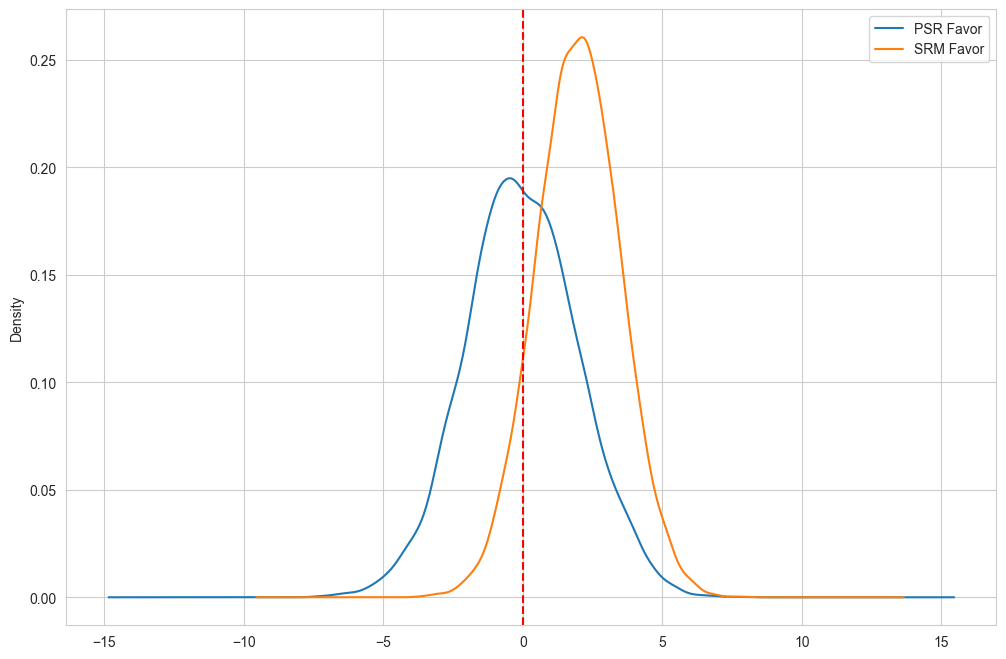

In [60]:
psr_favor = np.random.normal(0, 2, 10000)
strat_risk_favor = np.random.normal(2,1.5,10000)
df = pd.DataFrame({'PSR Favor': psr_favor, 'SRM Favor': strat_risk_favor})
df.plot(kind = 'kde', figsize = (12,8), grid = True)
plt.axvline(x = 0, ls = '--', c = 'r')
plt.show()

이 두 분포 사이에는 중복되는 영역이 있으므로, 두 metric 모두 상호적인 영역이 존재한다. 이와 같이, 두 기법은 서로 상호 보완적이라고 할 수 있다